## REGRESSION LOGISTIQUE
#### 1. Sélectionner les variables explicatives en utilisant l’algorithme Recursive feature elimination. 
ATTENTION : Cette méthode n’a pas encore été abordée en cours. Néanmoins, elle est simple à appliquer avec scikit-learn. Vous pouvez bien évidement choisir une autre méthode de sélection de variables explicatives.
#### 2. Elaborer un modèle de régression logistique pour prédire la variable alive en fonction des variables explicatives choisies.
#### 3. Conclure

---------------------------------------------------------------------------------------------------------------------

### Importer les librairies


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from numpy import set_printoptions

#Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Importer la dataset et l'explorer

In [2]:
data = pd.read_csv('trainClean.csv', sep=',', encoding='utf-8')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age_categories
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Young Adult
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Young Adult


#### Simuler (Dummy) les catégorielles features de la dataset

   ##### Compter le nombre de  catégorielles features que nous avons dans l'ensemble de données

In [3]:
categorical_feature_columns = list(set(data.columns) - set(data._get_numeric_data().columns))
categorical_feature_columns

['Sex', 'Age_categories', 'Ticket', 'Name', 'Embarked']

**Nous allons supprimer les deux colonnes: Nom et Ticket (car elles ne contiennent pas d'informations utiles pour nous) et facturer et aprés supprimer le reste des colonnes **

In [4]:
def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
data = create_dummies(data,"Sex")

In [6]:
data = create_dummies(data,"Age_categories")

In [7]:
data = create_dummies(data,"Embarked")

In [8]:
data=data.drop(['Name','Ticket','Sex','Sex_male','Age_categories','Embarked','PassengerId'], axis=1)
#data=data.drop(['Name','Ticket','Sex','Sex_male','Age_categories','Embarked','PassengerId'], axis=1)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 17 columns):
Survived                      889 non-null int64
Pclass                        889 non-null int64
Age                           889 non-null float64
SibSp                         889 non-null int64
Parch                         889 non-null int64
Fare                          889 non-null float64
Sex_female                    889 non-null uint8
Age_categories_Adult          889 non-null uint8
Age_categories_Child          889 non-null uint8
Age_categories_Infant         889 non-null uint8
Age_categories_Missing        889 non-null uint8
Age_categories_Senior         889 non-null uint8
Age_categories_Teenager       889 non-null uint8
Age_categories_Young Adult    889 non-null uint8
Embarked_C                    889 non-null uint8
Embarked_Q                    889 non-null uint8
Embarked_S                    889 non-null uint8
dtypes: float64(2), int64(4), uint8(11)
memory usage: 51.3

### Création d'un train set et validation set

In [10]:
X = data.drop(['Survived'], axis=1)
y = data['Survived']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=5)
#X.columns

In [11]:
print(X_train.shape,'\n')
print(X_valid.shape,'\n')
print(y_train.shape,'\n')
print(y_valid.shape,'\n')

(711, 16) 

(178, 16) 

(711,) 

(178,) 



###### Compter le nombre de passagers survivants et non survivants dans l'ensemble de données de validation

In [12]:
Alive=pd.DataFrame(y_valid, columns = ['Survived'])
Alive[Alive['Survived']==0].count()

Survived    119
dtype: int64

In [13]:
Alive[Alive['Survived']==1].count()

Survived    59
dtype: int64

### 1. Model de regression logistique en utilisant tout les features 

In [14]:
regLogistic=LogisticRegression(solver='newton-cg', multi_class='auto', penalty ='l2', random_state = None)

###### Fonction pour former, valider et évaluer le modèle de régression logistique

In [63]:
#from pandas_ml import ConfusionMatrix
def logisticeModel(columNames):
    logReg_model = regLogistic.fit(X_train[columNames], y_train)
    #Test the model
    y_pred = logReg_model.predict(X_valid[columNames])
    
    #print(classification_report(y_valid, y_pred))

    print('\033[1m' + 'Accuracy score: '+'\033[0m',accuracy_score(y_valid, y_pred)) # le plus important pour le moment; précisément la première ligne

    # Matrice de confusion
    ax= plt.subplot()
    sns.heatmap(confusion_matrix(y_valid,y_pred), annot=True, ax = ax ,fmt='g'); #annot=True to annotate cells
    ax.set_xlabel('Valeurs prédites');ax.set_ylabel('Valeurs réelles'); 
    ax.set_title('Confusion Matrix'); 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.xaxis.set_ticklabels(['Décédé', 'Vivante']); ax.yaxis.set_ticklabels(['Décédé', 'Vivante']);
    
    print('\n')
    # Calculer et visualiser ROC et AUC
    proba = logReg_model.predict_proba(X_valid[columNames])
    fpr0, tpr0, thresholds0 = roc_curve(y_valid, proba[:, 1], pos_label=logReg_model.classes_[1], drop_intermediate=False)
    #thresholds0.shape
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.plot([0, 1], [0, 1], 'k--')
    aucf = auc(fpr0, tpr0)
    ax.plot(fpr0, tpr0, label='auc=%1.5f' % aucf)
    ax.set_title('Courbe ROC')
    ax.text(0.5, 0.3, "plus mauvais que\nle hasard dans\ncette zone")
    ax.legend();

###### Les résultats du premier modèle en prenant toutes les features de l'ensemble de données

Accuracy score:  0.8539325842696629




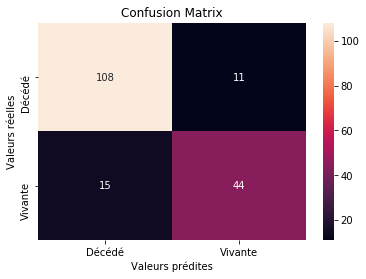

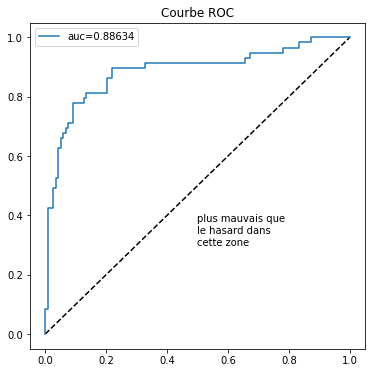

In [64]:
logisticeModel(X_train.columns.tolist())

<p> Même si nous avons obtenu une bonne valeur pour la précision avec toutes les fonctionnalités, nous avons essayé de choisir les fonctionnalités les plus explicatives pour minimiser le temps total de training, pour cela nous avons essayé plusieurs algorithmes pour la sélection des features, qui sont: Recursive feature elimination (RFE), Recursive feature elimination avec cross-validation (RFECV), Univariate Feature Selection (SelectKBest), PCA, features meilleure combinaison </p>

### 2.Model de regression logistique par sélectionner les variables explicatives en utilisant l’algorithme Recursive feature elimination (RFE). 

<p> Étant donné un estimateur externe qui attribue des poids aux caractéristiques (par exemple, les coefficients d'un modèle linéaire), l'élimination récursive des caractéristiques (RFE) consiste à sélectionner les caractéristiques en considérant récursivement des ensembles de plus en plus petits de caractéristiques. Premièrement, l'estimateur est formé sur l'ensemble initial de caractéristiques et des poids sont attribués à chacun d'eux. Ensuite, les entités dont les poids absolus sont les plus petits sont élaguées à partir des entités définies actuellement. Cette procédure est répétée récursivement sur l'ensemble élagué jusqu'à ce que le nombre souhaité de caractéristiques à sélectionner soit finalement atteint. </p>

In [56]:
from sklearn.feature_selection import RFE
# utilise regression logistique comme estimator
# classer toutes les features, c.a.d poursuivre l'élimination jusqu'à la dernière
rfe=RFE(regLogistic,n_features_to_select=1)
names=X_train.columns.tolist()
rfe.fit(X_train,y_train)
print("Features triées par leurs rangs ")
print(sorted(zip(map(lambda x: round(x,4),rfe.ranking_),names)))

Features triées par leurs rangs 
[(1, 'Sex_female'), (2, 'Age_categories_Infant'), (3, 'Pclass'), (4, 'Age_categories_Senior'), (5, 'Age_categories_Adult'), (6, 'Embarked_S'), (7, 'Age_categories_Child'), (8, 'SibSp'), (9, 'Age_categories_Missing'), (10, 'Age_categories_Teenager'), (11, 'Parch'), (12, 'Embarked_C'), (13, 'Embarked_Q'), (14, 'Age_categories_Young Adult'), (15, 'Age'), (16, 'Fare')]


Accuracy score:  0.8651685393258427




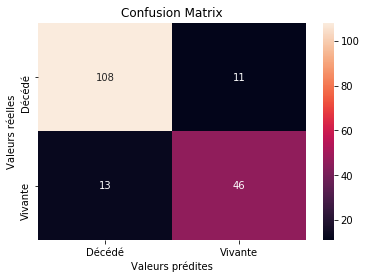

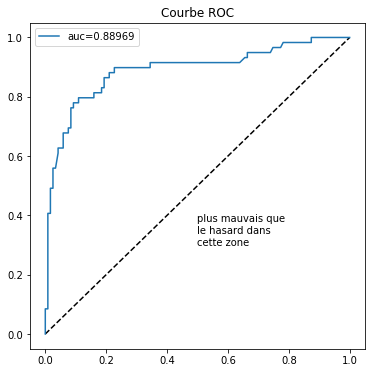

In [65]:
#colNmae=['Sex_female','Age_categories_Infant','Pclass',]
colNmae=['Sex_female', 'Age_categories_Infant', 'Pclass', 'Age_categories_Senior', 'Age_categories_Adult', 'Embarked_S', 'Age_categories_Child', 'SibSp', 'Age_categories_Missing', 'Age_categories_Teenager', 'Parch','Age']
#colNmae=['Sex_female', 'Pclass', 'Embarked_S', 'Embarked_C', 'SibSp', 'Parch','Embarked_Q','Age',]
logisticeModel(colNmae)

### 3. Model regression logistique par sélectionner les variables explicatives en utilisant l’algorithme Recursive feature elimination avec cross-validation (RFECV). 

In [58]:
rfecv = RFECV(estimator=regLogistic, step=1, cv=5, scoring='accuracy')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 14
Best features : Index(['Pclass', 'SibSp', 'Parch', 'Sex_female', 'Age_categories_Adult',
       'Age_categories_Child', 'Age_categories_Infant',
       'Age_categories_Missing', 'Age_categories_Senior',
       'Age_categories_Teenager', 'Age_categories_Young Adult', 'Embarked_C',
       'Embarked_Q', 'Embarked_S'],
      dtype='object')


In [59]:
rfecv.score(X_valid, y_valid)

0.8539325842696629

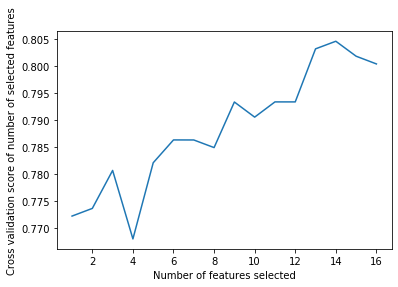

In [60]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [61]:
# Get columns to keep and create new dataframe with those only
cols = rfecv.get_support(indices=True)
#features_df_new = X_train.iloc[:,cols].names
#features_df_new
selectedColumns=X_train.columns[cols].tolist()
selectedColumns

['Pclass',
 'SibSp',
 'Parch',
 'Sex_female',
 'Age_categories_Adult',
 'Age_categories_Child',
 'Age_categories_Infant',
 'Age_categories_Missing',
 'Age_categories_Senior',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']

Accuracy score:  0.8539325842696629




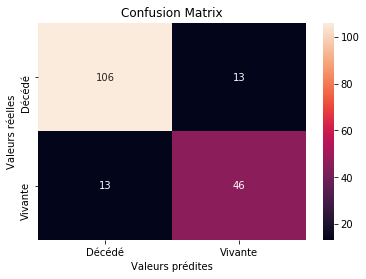

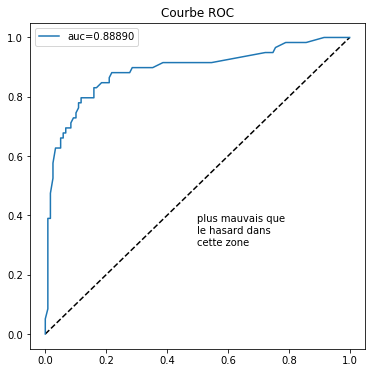

In [66]:
logisticeModel(selectedColumns)

### 4. Model de regression logistique en utilisant SelectKBest

<p> La sélection des fonctionnalités univariées (Univariate feature selection) fonctionne en sélectionnant les meilleures features sur la base de tests statistiques univariés. Il peut être considéré comme une étape de prétraitement d'un estimateur.
    
  SelectKBest est une méthode de sélection des fonctionnalités prise en charge par Scikit-learn, qui supprime toutes les fonctionnalités ayant le score le plus élevé, sauf les k.
  
  SelectKBest prend en entrée une fonction de notation et renvoie des scores univariés pour chaque feature.
  
    Les fonction de notation pour la régression: f_regression, mutual_info_regression
    et pour la classification: chi2, f_classif, mutual_info_classif 
    
</p>

In [67]:
# Create and fit selector
#selector = SelectKBest(f_classif, k=4)
#selector = SelectKBest(mutual_info_classif, k=5)
selector = SelectKBest(chi2, k=4)
selector.fit(X_train,y_train)

SelectKBest(k=4, score_func=<function chi2 at 0x000001CFDDECC168>)

In [68]:
# what are scores for the features
for i in range(len(selector.scores_)):
	print('Feature %d: %f' % (i, selector.scores_[i]))

Feature 0: 24.310452
Feature 1: 40.059234
Feature 2: 0.809887
Feature 3: 4.949948
Feature 4: 3817.384852
Feature 5: 121.964750
Feature 6: 0.132538
Feature 7: 0.091803
Feature 8: 20.233726
Feature 9: 4.369918
Feature 10: 2.711519
Feature 11: 0.087602
Feature 12: 0.252016
Feature 13: 18.865836
Feature 14: 0.017108
Feature 15: 4.845628


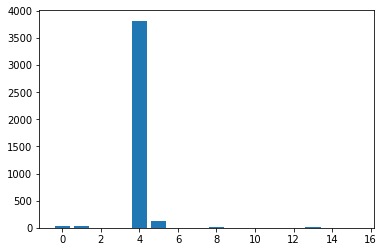

In [69]:
# plot the scores
from matplotlib import pyplot
pyplot.bar([i for i in range(len(selector.scores_))], selector.scores_)
pyplot.show()

In [70]:
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
#features_df_new = X_train.iloc[:,cols].names
#features_df_new
selectedColumns=X_train.columns[cols].tolist()
selectedColumns

['Pclass', 'Age', 'Fare', 'Sex_female']

Accuracy score:  0.8370786516853933




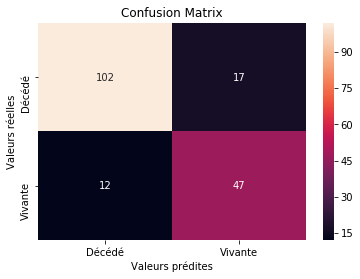

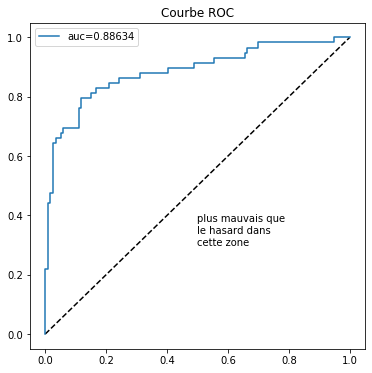

In [71]:
logisticeModel(selectedColumns)

### 5. Model de regression logistique en utilisant PCA

In [72]:
# normalize data
from sklearn import preprocessing

data_scaled = pd.DataFrame(preprocessing.scale(X_train),columns = X_train.columns) 
model = PCA(n_components=2).fit(X_train)
X_pc = model.transform(X_train)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names =X_train.columns.tolist()

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,Fare
1,PC2,Age


Accuracy score:  0.6235955056179775




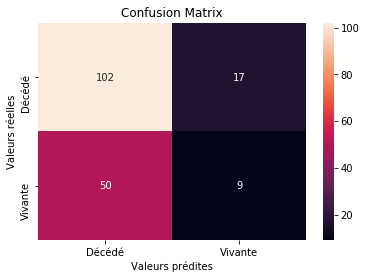

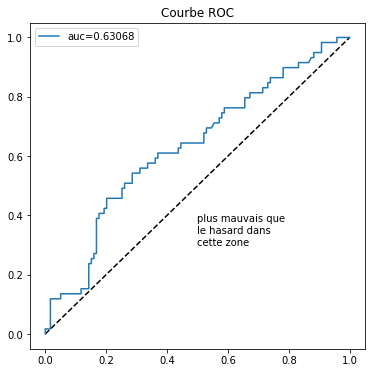

In [73]:
c=df[1].tolist()
logisticeModel(c)

### 6. Model de regression logistique en utilisant la meilleure combinaison entre les features

In [74]:
import itertools
def bruteforce(df):
    features = df.drop(['Survived'], axis=1)
    target = df['Survived']
    
    combs = []
    for i in range(2, len(features.columns)):
        for comb in itertools.combinations(features, i):
            combs.append(comb)
    
    rows = []
    for i in range(len(combs)):
        X_train, X_test, y_train, y_test = train_test_split(features[list(combs[i])], target, test_size = 0.2, random_state=5)
        clf = LogisticRegression(solver='newton-cg', multi_class='auto', penalty ='l2', random_state = None)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
        M = confusion_matrix(y_test, pred)
        rows.append([combs[i], clf.score(X_test, y_test), roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]), M[0,1], M[1,0]])
        #print('%s/%s - %s'%(i, len(combs), i/len(combs)*100))
    return rows

In [347]:
result = pd.DataFrame(bruteforce(data), columns=['comb', 'score', 'auc', 'fp', 'tn'])

C:\Users\utilisateur\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\utilisateur\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
C:\Users\utilisateur\Anaconda3\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
C:\Users\utilisateur\Anaconda3\lib\site-packages\

In [ ]:
max_score = result[result['score'] == result['score'].max()]
max_score[max_score['auc'] == max_score['auc'].max()]

Accuracy score:  0.8370786516853933




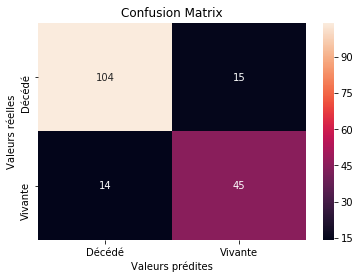

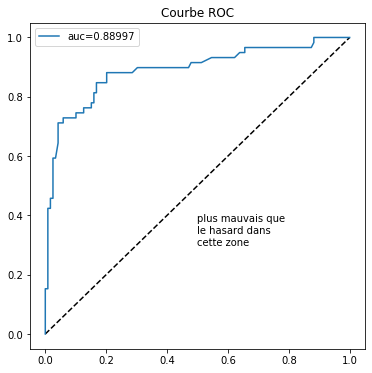

In [76]:
col=['Pclass', 'Age', 'SibSp', 'Parch', 'Sex_female', 'Age_categories_Infant', 'Age_categories_Senior', 'Embarked_Q']
logisticeModel(col)

***Après avoir essayé différentes méthodes de sélection d'entités, nous concluons que la meilleure méthode pour l'ensemble de données dans notre main est RFE car elle nous donne la meilleure précision (87).***